# Students Adaptability Level In Online Education 

* __Student name:__ Emily Marsh
* __Student pace:__ Flex
* __Scheduled project review date/time:__
* __Instructor name:__ Joe Comeaux

# Introduction

During the COVID pandemic many students were suddenly thrust into a digital only learning enviorment. Some student adapted to this new learning enviorment better then others and those who did not suffered a huge set back in terms of their education. However, online learning in here to stay. The Department of Education has commissioned this project to create a model to predict a students adaptiblity level in order to identify students who need more assistance adapting to online learning and how best to help them.  

# Business Objective

This project will assist the Federal Department of Education by creating a model that will predict a students level of adaptability based on twelve independent factors. The Department will use this model to identify students who are at risk of being low or moderate level of adaptablity to online learning. The model will also be used to identify which features are the most important for acheive a high level of adaptability. These features, once discovered, can be used to recommend modifications for online curriculum support for students and recommendations that the Department of Education can share with educators, parents and students. Students can have three different levels of adaptabiliy to online education:

* __Low__ 
* __Moderate__
* __High__

Since the model will be used for identifying feature importance as well as predicting the level of adaptibility of the student, F1 Score will be used to assess the accuracy of the models developed using the dataset. The reason for using an F1 score versus any other metrics of accuracy is that eliminating false negatives and false positives will ensure the accuracy of the feature recommendations. This model will be designed to be proactive as well as reactive, therefore eliminating false positives and negatives will be the goal. 

# Dataset

The dataset used for this project is from Kaggle. The information in the dataset was collected using an online and offline survey and was sent to students at varying education levels in Bangledesh. Overall, the dataset contains 1205 survey responses collected between Dec 10th 2020 and Feb 5th 2021. The 14 attributes for each entry are are age, gender, level, govt./non-govt. institution, location, IT student or not, educational background, load shedding level, internet quality, class-time, the economic condition of the family, device type used while attending classes, and institution’s own LMS availability. A table from the paper published about the methodology of this dataset is included below with a detailed description of each feature.

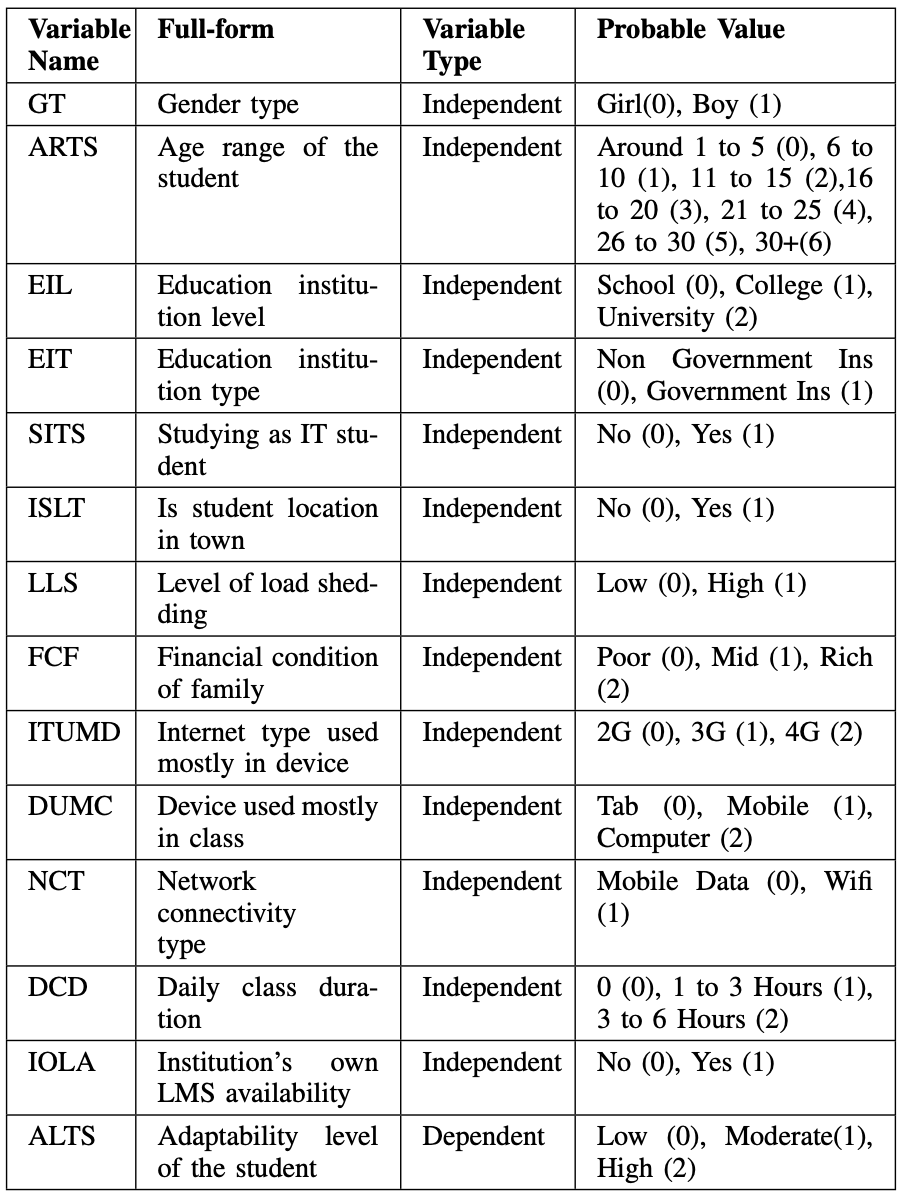

## Import Libraries

In [1]:
#importing relevant tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import shap
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

/Users/emilymarsh/opt/anaconda3/envs/learn-env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/emilymarsh/opt/anaconda3/envs/learn-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654), (0.15615526, 0.47913212, 0.54850526), (0.11131735, 0.39155635, 0.53422678), (0.14573579, 0.29354139, 0.49847009)]


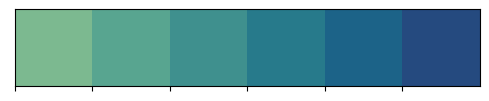

In [2]:
#creating a consistent color palatte for visualizations
pal = sns.color_palette("crest")
print(pal)
sns.palplot(pal)

## Initial Dataset Exploration

In [3]:
#importing dataset into a pandas dataframe
data = pd.read_csv('students_adaptability_level_online_education 2.csv')

In [4]:
#initial overview of datasets columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [5]:
data['Adaptivity Level'].value_counts()

Moderate    625
Low         480
High        100
Name: Adaptivity Level, dtype: int64

## Data Understanding

Within this dataset, all fourteen features are all object datatypes. This means that all fourteen features will need to be processed in order to create a model that will be able to properly run using the information contained in this dataset. In order to choose the appropriate categorical processing tool, more information will need to be gleaned about the amount of values for each categorical feature. Additional investigation will also be necessary to determine if there are any null values in the dataset that could interfere with accurate results. 

## Check for Null Values

In [6]:
# checking for null values and returning it as a pandas series
empty=data.isna().sum()
empty

Gender                 0
Age                    0
Education Level        0
Institution Type       0
IT Student             0
Location               0
Load-shedding          0
Financial Condition    0
Internet Type          0
Network Type           0
Class Duration         0
Self Lms               0
Device                 0
Adaptivity Level       0
dtype: int64

After additional investigation, the dataset appears to contain no null values. Therefore no rows or columns will need to be dropped from the dataset. 

## Checking Datatypes

In order to use the information in the dataset to create a model, features must be either a float or integer. In order to convert these categorical columns several pre-processing tools are available for use. Deciding which one to use will be determined by the values in each column. 

In [7]:
# examining the data types of the df
data.dtypes.value_counts()

object    14
dtype: int64

# Categorical Data Processing

There are two two types of categorical data in the dataset. One is binary, meaning there are only two possible values. The other is multi-categorical, meaning more then two possible values for the feature. These two categorical types will be processed differently in order to limit the amount of columns and as a result the processing time needed to develop the appropriate model for the dataset.

## Processing Adaptivity Level

Since the different levels of adaptability have an inherent ordered relationship, this pre-processing will assing numeric values that reflect this relationship to make interpretation easier later on. 

In [8]:
# assigning numeric values to Adaptivity Level

data['Adaptivity Level'] = pd.Categorical(data['Adaptivity Level'], ['Low', 'Moderate', 'High'], ordered=True)
data['Adaptivity Level'] = data['Adaptivity Level'].cat.codes

In [9]:
#checking numeric values

data['Adaptivity Level'].value_counts()

1    625
0    480
2    100
Name: Adaptivity Level, dtype: int64

The categorical feature Adaptivity Level has now been processed to be a integer data type with 0 correlating with the low values, 1 with the moderate values, and 2 with high values of the original dataset. 

## Processing Aspects of Dataset

In [10]:
#examining unique values

data.nunique()

Gender                 2
Age                    6
Education Level        3
Institution Type       2
IT Student             2
Location               2
Load-shedding          2
Financial Condition    3
Internet Type          2
Network Type           3
Class Duration         3
Self Lms               2
Device                 3
Adaptivity Level       3
dtype: int64

By exploring the total number of distinct values in each feature, it becomes apparent that there are 7 binary features and 7 multi categorical features. 

In [11]:
#inspecting values

data.head()

Gender    Age Education Level Institution Type IT Student Location  \
0    Boy  21-25      University   Non Government         No      Yes   
1   Girl  21-25      University   Non Government         No      Yes   
2   Girl  16-20         College       Government         No      Yes   
3   Girl  11-15          School   Non Government         No      Yes   
4   Girl  16-20          School   Non Government         No      Yes   

  Load-shedding Financial Condition Internet Type Network Type Class Duration  \
0           Low                 Mid          Wifi           4G            3-6   
1          High                 Mid   Mobile Data           4G            1-3   
2           Low                 Mid          Wifi           4G            1-3   
3           Low                 Mid   Mobile Data           4G            1-3   
4           Low                Poor   Mobile Data           3G              0   

  Self Lms  Device  Adaptivity Level  
0       No     Tab                 1  
1      Yes  Mobile                 1  
2       No  Mobile                 1  
3       No  Mobile                 1  
4       No  Mobile                 0

# Binary Categories

For the 7 Binary Categories in the Dataset, Ordinal Encoding will be used since this will allow the column to be encoded with numerical values and without expanding the original one column into two values. 

## Processing Gender

In [12]:
# Create a variable that contains the relevant column from data
gender_aspects = data[["Gender"]]

# Instantiate an OrdinalEncoder
encoder_ordinal = OrdinalEncoder()

# Fit the encoder on gender_aspects
encoder_ordinal.fit(gender_aspects)

# Inspect the categories of the fitted encoder
encoder_ordinal.categories_[0]

array(['Boy', 'Girl'], dtype=object)

In [13]:
# Transform gender_aspects using the encoder and assign the result to gender_encoded_aspect
gender_encoded_aspect = encoder_ordinal.transform(gender_aspects)

# Flatten for appropriate shape
gender_encoded_aspect = gender_encoded_aspect.flatten()

# Visually inspect gender_encoded_aspect
gender_encoded_aspect

array([0., 1., 1., ..., 0., 1., 1.])

In [14]:
# Replace value of Gender
data["Gender"] = gender_encoded_aspect

# Visually inspect data
data

Gender    Age Education Level Institution Type IT Student Location  \
0        0.0  21-25      University   Non Government         No      Yes   
1        1.0  21-25      University   Non Government         No      Yes   
2        1.0  16-20         College       Government         No      Yes   
3        1.0  11-15          School   Non Government         No      Yes   
4        1.0  16-20          School   Non Government         No      Yes   
...      ...    ...             ...              ...        ...      ...   
1200     1.0  16-20         College   Non Government         No      Yes   
1201     1.0  16-20         College   Non Government         No       No   
1202     0.0  11-15          School   Non Government         No      Yes   
1203     1.0  16-20         College   Non Government         No       No   
1204     1.0  11-15          School   Non Government         No      Yes   

     Load-shedding Financial Condition Internet Type Network Type  \
0              Low                 Mid          Wifi           4G   
1             High                 Mid   Mobile Data           4G   
2              Low                 Mid          Wifi           4G   
3              Low                 Mid   Mobile Data           4G   
4              Low                Poor   Mobile Data           3G   
...            ...                 ...           ...          ...   
1200           Low                 Mid          Wifi           4G   
1201          High                 Mid          Wifi           4G   
1202           Low                 Mid   Mobile Data           3G   
1203           Low                 Mid          Wifi           4G   
1204           Low                Poor   Mobile Data           3G   

     Class Duration Self Lms  Device  Adaptivity Level  
0               3-6       No     Tab                 1  
1               1-3      Yes  Mobile                 1  
2               1-3       No  Mobile                 1  
3               1-3       No  Mobile                 1  
4                 0       No  Mobile                 0  
...             ...      ...     ...               ...  
1200            1-3       No  Mobile                 0  
1201            3-6       No  Mobile                 1  
1202            1-3       No  Mobile                 1  
1203            1-3       No  Mobile                 0  
1204            1-3       No  Mobile                 1  

[1205 rows x 14 columns]

The Gender categorical feature was successfully processed to have a binary integer value, therefore conveying the same information but in a way that can be used to create an appropriate model. This same process will be used on the remaining 6 binary categorical features. 

## Processing Institution Type

In [15]:
# processing the Instituation Type binary feature
instu_aspects = data[["Institution Type"]]
encoder_ordinal.fit(instu_aspects)
instu_encoded_aspect = encoder_ordinal.transform(instu_aspects)
data["Institution Type"] = instu_encoded_aspect

# Visually inspect aspects
data

Gender    Age Education Level  Institution Type IT Student Location  \
0        0.0  21-25      University               1.0         No      Yes   
1        1.0  21-25      University               1.0         No      Yes   
2        1.0  16-20         College               0.0         No      Yes   
3        1.0  11-15          School               1.0         No      Yes   
4        1.0  16-20          School               1.0         No      Yes   
...      ...    ...             ...               ...        ...      ...   
1200     1.0  16-20         College               1.0         No      Yes   
1201     1.0  16-20         College               1.0         No       No   
1202     0.0  11-15          School               1.0         No      Yes   
1203     1.0  16-20         College               1.0         No       No   
1204     1.0  11-15          School               1.0         No      Yes   

     Load-shedding Financial Condition Internet Type Network Type  \
0              Low                 Mid          Wifi           4G   
1             High                 Mid   Mobile Data           4G   
2              Low                 Mid          Wifi           4G   
3              Low                 Mid   Mobile Data           4G   
4              Low                Poor   Mobile Data           3G   
...            ...                 ...           ...          ...   
1200           Low                 Mid          Wifi           4G   
1201          High                 Mid          Wifi           4G   
1202           Low                 Mid   Mobile Data           3G   
1203           Low                 Mid          Wifi           4G   
1204           Low                Poor   Mobile Data           3G   

     Class Duration Self Lms  Device  Adaptivity Level  
0               3-6       No     Tab                 1  
1               1-3      Yes  Mobile                 1  
2               1-3       No  Mobile                 1  
3               1-3       No  Mobile                 1  
4                 0       No  Mobile                 0  
...             ...      ...     ...               ...  
1200            1-3       No  Mobile                 0  
1201            3-6       No  Mobile                 1  
1202            1-3       No  Mobile                 1  
1203            1-3       No  Mobile                 0  
1204            1-3       No  Mobile                 1  

[1205 rows x 14 columns]

## Processing IT Student

In [16]:
# processing the IT Students binary feature
it_stu_aspects = data[["IT Student"]]
encoder_ordinal.fit(it_stu_aspects)
it_stu_encoded_aspects = encoder_ordinal.transform(it_stu_aspects)
data["IT Student"] = it_stu_encoded_aspects

# Visually inspect aspects
data

Gender    Age Education Level  Institution Type  IT Student Location  \
0        0.0  21-25      University               1.0         0.0      Yes   
1        1.0  21-25      University               1.0         0.0      Yes   
2        1.0  16-20         College               0.0         0.0      Yes   
3        1.0  11-15          School               1.0         0.0      Yes   
4        1.0  16-20          School               1.0         0.0      Yes   
...      ...    ...             ...               ...         ...      ...   
1200     1.0  16-20         College               1.0         0.0      Yes   
1201     1.0  16-20         College               1.0         0.0       No   
1202     0.0  11-15          School               1.0         0.0      Yes   
1203     1.0  16-20         College               1.0         0.0       No   
1204     1.0  11-15          School               1.0         0.0      Yes   

     Load-shedding Financial Condition Internet Type Network Type  \
0              Low                 Mid          Wifi           4G   
1             High                 Mid   Mobile Data           4G   
2              Low                 Mid          Wifi           4G   
3              Low                 Mid   Mobile Data           4G   
4              Low                Poor   Mobile Data           3G   
...            ...                 ...           ...          ...   
1200           Low                 Mid          Wifi           4G   
1201          High                 Mid          Wifi           4G   
1202           Low                 Mid   Mobile Data           3G   
1203           Low                 Mid          Wifi           4G   
1204           Low                Poor   Mobile Data           3G   

     Class Duration Self Lms  Device  Adaptivity Level  
0               3-6       No     Tab                 1  
1               1-3      Yes  Mobile                 1  
2               1-3       No  Mobile                 1  
3               1-3       No  Mobile                 1  
4                 0       No  Mobile                 0  
...             ...      ...     ...               ...  
1200            1-3       No  Mobile                 0  
1201            3-6       No  Mobile                 1  
1202            1-3       No  Mobile                 1  
1203            1-3       No  Mobile                 0  
1204            1-3       No  Mobile                 1  

[1205 rows x 14 columns]

## Processing Location

In [17]:
# processing the Location binary feature
loca_aspects = data[["Location"]]
encoder_ordinal.fit(loca_aspects)
loca_encoded_aspects = encoder_ordinal.transform(loca_aspects)
data["Location"] = loca_encoded_aspects

# Visually inspect aspects
data

Gender    Age Education Level  Institution Type  IT Student  Location  \
0        0.0  21-25      University               1.0         0.0       1.0   
1        1.0  21-25      University               1.0         0.0       1.0   
2        1.0  16-20         College               0.0         0.0       1.0   
3        1.0  11-15          School               1.0         0.0       1.0   
4        1.0  16-20          School               1.0         0.0       1.0   
...      ...    ...             ...               ...         ...       ...   
1200     1.0  16-20         College               1.0         0.0       1.0   
1201     1.0  16-20         College               1.0         0.0       0.0   
1202     0.0  11-15          School               1.0         0.0       1.0   
1203     1.0  16-20         College               1.0         0.0       0.0   
1204     1.0  11-15          School               1.0         0.0       1.0   

     Load-shedding Financial Condition Internet Type Network Type  \
0              Low                 Mid          Wifi           4G   
1             High                 Mid   Mobile Data           4G   
2              Low                 Mid          Wifi           4G   
3              Low                 Mid   Mobile Data           4G   
4              Low                Poor   Mobile Data           3G   
...            ...                 ...           ...          ...   
1200           Low                 Mid          Wifi           4G   
1201          High                 Mid          Wifi           4G   
1202           Low                 Mid   Mobile Data           3G   
1203           Low                 Mid          Wifi           4G   
1204           Low                Poor   Mobile Data           3G   

     Class Duration Self Lms  Device  Adaptivity Level  
0               3-6       No     Tab                 1  
1               1-3      Yes  Mobile                 1  
2               1-3       No  Mobile                 1  
3               1-3       No  Mobile                 1  
4                 0       No  Mobile                 0  
...             ...      ...     ...               ...  
1200            1-3       No  Mobile                 0  
1201            3-6       No  Mobile                 1  
1202            1-3       No  Mobile                 1  
1203            1-3       No  Mobile                 0  
1204            1-3       No  Mobile                 1  

[1205 rows x 14 columns]

## Processing Load Shedding

In [18]:
# processing the Load Shedding binary feature
load_aspects = data[["Load-shedding"]]
encoder_ordinal.fit(load_aspects)
load_encoded_aspects = encoder_ordinal.transform(load_aspects)
data["Load-shedding"] = load_encoded_aspects

# Visually inspect aspects
data

Gender    Age Education Level  Institution Type  IT Student  Location  \
0        0.0  21-25      University               1.0         0.0       1.0   
1        1.0  21-25      University               1.0         0.0       1.0   
2        1.0  16-20         College               0.0         0.0       1.0   
3        1.0  11-15          School               1.0         0.0       1.0   
4        1.0  16-20          School               1.0         0.0       1.0   
...      ...    ...             ...               ...         ...       ...   
1200     1.0  16-20         College               1.0         0.0       1.0   
1201     1.0  16-20         College               1.0         0.0       0.0   
1202     0.0  11-15          School               1.0         0.0       1.0   
1203     1.0  16-20         College               1.0         0.0       0.0   
1204     1.0  11-15          School               1.0         0.0       1.0   

      Load-shedding Financial Condition Internet Type Network Type  \
0               1.0                 Mid          Wifi           4G   
1               0.0                 Mid   Mobile Data           4G   
2               1.0                 Mid          Wifi           4G   
3               1.0                 Mid   Mobile Data           4G   
4               1.0                Poor   Mobile Data           3G   
...             ...                 ...           ...          ...   
1200            1.0                 Mid          Wifi           4G   
1201            0.0                 Mid          Wifi           4G   
1202            1.0                 Mid   Mobile Data           3G   
1203            1.0                 Mid          Wifi           4G   
1204            1.0                Poor   Mobile Data           3G   

     Class Duration Self Lms  Device  Adaptivity Level  
0               3-6       No     Tab                 1  
1               1-3      Yes  Mobile                 1  
2               1-3       No  Mobile                 1  
3               1-3       No  Mobile                 1  
4                 0       No  Mobile                 0  
...             ...      ...     ...               ...  
1200            1-3       No  Mobile                 0  
1201            3-6       No  Mobile                 1  
1202            1-3       No  Mobile                 1  
1203            1-3       No  Mobile                 0  
1204            1-3       No  Mobile                 1  

[1205 rows x 14 columns]

## Processing Internet Type

In [19]:
# processing the Internet Type binary feature
internet_aspects = data[["Internet Type"]]
encoder_ordinal.fit(internet_aspects)
internet_encoded_aspects = encoder_ordinal.transform(internet_aspects)
data["Internet Type"] = internet_encoded_aspects

# Visually inspect aspects
data

Gender    Age Education Level  Institution Type  IT Student  Location  \
0        0.0  21-25      University               1.0         0.0       1.0   
1        1.0  21-25      University               1.0         0.0       1.0   
2        1.0  16-20         College               0.0         0.0       1.0   
3        1.0  11-15          School               1.0         0.0       1.0   
4        1.0  16-20          School               1.0         0.0       1.0   
...      ...    ...             ...               ...         ...       ...   
1200     1.0  16-20         College               1.0         0.0       1.0   
1201     1.0  16-20         College               1.0         0.0       0.0   
1202     0.0  11-15          School               1.0         0.0       1.0   
1203     1.0  16-20         College               1.0         0.0       0.0   
1204     1.0  11-15          School               1.0         0.0       1.0   

      Load-shedding Financial Condition  Internet Type Network Type  \
0               1.0                 Mid            1.0           4G   
1               0.0                 Mid            0.0           4G   
2               1.0                 Mid            1.0           4G   
3               1.0                 Mid            0.0           4G   
4               1.0                Poor            0.0           3G   
...             ...                 ...            ...          ...   
1200            1.0                 Mid            1.0           4G   
1201            0.0                 Mid            1.0           4G   
1202            1.0                 Mid            0.0           3G   
1203            1.0                 Mid            1.0           4G   
1204            1.0                Poor            0.0           3G   

     Class Duration Self Lms  Device  Adaptivity Level  
0               3-6       No     Tab                 1  
1               1-3      Yes  Mobile                 1  
2               1-3       No  Mobile                 1  
3               1-3       No  Mobile                 1  
4                 0       No  Mobile                 0  
...             ...      ...     ...               ...  
1200            1-3       No  Mobile                 0  
1201            3-6       No  Mobile                 1  
1202            1-3       No  Mobile                 1  
1203            1-3       No  Mobile                 0  
1204            1-3       No  Mobile                 1  

[1205 rows x 14 columns]

## Processing Self Lms

In [20]:
# processing the Self Lms binary feature
self_aspects = data[["Self Lms"]]
encoder_ordinal.fit(self_aspects)
self_encoded_aspects = encoder_ordinal.transform(self_aspects)
data["Self Lms"] = self_encoded_aspects

# Visually inspect aspects
data

Gender    Age Education Level  Institution Type  IT Student  Location  \
0        0.0  21-25      University               1.0         0.0       1.0   
1        1.0  21-25      University               1.0         0.0       1.0   
2        1.0  16-20         College               0.0         0.0       1.0   
3        1.0  11-15          School               1.0         0.0       1.0   
4        1.0  16-20          School               1.0         0.0       1.0   
...      ...    ...             ...               ...         ...       ...   
1200     1.0  16-20         College               1.0         0.0       1.0   
1201     1.0  16-20         College               1.0         0.0       0.0   
1202     0.0  11-15          School               1.0         0.0       1.0   
1203     1.0  16-20         College               1.0         0.0       0.0   
1204     1.0  11-15          School               1.0         0.0       1.0   

      Load-shedding Financial Condition  Internet Type Network Type  \
0               1.0                 Mid            1.0           4G   
1               0.0                 Mid            0.0           4G   
2               1.0                 Mid            1.0           4G   
3               1.0                 Mid            0.0           4G   
4               1.0                Poor            0.0           3G   
...             ...                 ...            ...          ...   
1200            1.0                 Mid            1.0           4G   
1201            0.0                 Mid            1.0           4G   
1202            1.0                 Mid            0.0           3G   
1203            1.0                 Mid            1.0           4G   
1204            1.0                Poor            0.0           3G   

     Class Duration  Self Lms  Device  Adaptivity Level  
0               3-6       0.0     Tab                 1  
1               1-3       1.0  Mobile                 1  
2               1-3       0.0  Mobile                 1  
3               1-3       0.0  Mobile                 1  
4                 0       0.0  Mobile                 0  
...             ...       ...     ...               ...  
1200            1-3       0.0  Mobile                 0  
1201            3-6       0.0  Mobile                 1  
1202            1-3       0.0  Mobile                 1  
1203            1-3       0.0  Mobile                 0  
1204            1-3       0.0  Mobile                 1  

[1205 rows x 14 columns]

In [21]:
#inspecting dataset to confirm that all binary categorical features have been encoded
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               1205 non-null   float64
 1   Age                  1205 non-null   object 
 2   Education Level      1205 non-null   object 
 3   Institution Type     1205 non-null   float64
 4   IT Student           1205 non-null   float64
 5   Location             1205 non-null   float64
 6   Load-shedding        1205 non-null   float64
 7   Financial Condition  1205 non-null   object 
 8   Internet Type        1205 non-null   float64
 9   Network Type         1205 non-null   object 
 10  Class Duration       1205 non-null   object 
 11  Self Lms             1205 non-null   float64
 12  Device               1205 non-null   object 
 13  Adaptivity Level     1205 non-null   int8   
dtypes: float64(7), int8(1), object(6)
memory usage: 123.7+ KB


All 7 binary categorical features have been successfully encoded to float data types. These features are now ready to be used in model building. 

## Multi Feature Categories

 For features that have more then two values, one hot encoder will be used so that the model will be able to determine the effects each of the categories have on the dependent variable. One hot encoder will split the possible values of the feature so that each value will have it's own individual column with a numerical value. 

## Processing Age

In [22]:
#create a variable
age_aspect = data[["Age"]]

# Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")

# Fit the encoder on the age_aspect
ohe.fit(age_aspect)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['1-5', '11-15', '16-20', '21-25', '26-30', '6-10'], dtype=object)]

In [23]:
# Transform age_aspect using the encoder and assign the result to age_aspect_encoded
age_aspect_encoded = ohe.transform(age_aspect)

# Visually inspect age_aspect_encoded
age_aspect_encoded

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [24]:
# Make the transformed data into a dataframe
age_aspect_encoded = pd.DataFrame(
    # Pass in NumPy array
    age_aspect_encoded,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match data's index
    index=data.index
)

# Visually inspect new dataframe
age_aspect_encoded

1-5  11-15  16-20  21-25  26-30  6-10
0     0.0    0.0    0.0    1.0    0.0   0.0
1     0.0    0.0    0.0    1.0    0.0   0.0
2     0.0    0.0    1.0    0.0    0.0   0.0
3     0.0    1.0    0.0    0.0    0.0   0.0
4     0.0    0.0    1.0    0.0    0.0   0.0
...   ...    ...    ...    ...    ...   ...
1200  0.0    0.0    1.0    0.0    0.0   0.0
1201  0.0    0.0    1.0    0.0    0.0   0.0
1202  0.0    1.0    0.0    0.0    0.0   0.0
1203  0.0    0.0    1.0    0.0    0.0   0.0
1204  0.0    1.0    0.0    0.0    0.0   0.0

[1205 rows x 6 columns]

In [25]:
# Drop original Age column
data.drop("Age", axis=1, inplace=True)

# Visually inspect data
data

Gender Education Level  Institution Type  IT Student  Location  \
0        0.0      University               1.0         0.0       1.0   
1        1.0      University               1.0         0.0       1.0   
2        1.0         College               0.0         0.0       1.0   
3        1.0          School               1.0         0.0       1.0   
4        1.0          School               1.0         0.0       1.0   
...      ...             ...               ...         ...       ...   
1200     1.0         College               1.0         0.0       1.0   
1201     1.0         College               1.0         0.0       0.0   
1202     0.0          School               1.0         0.0       1.0   
1203     1.0         College               1.0         0.0       0.0   
1204     1.0          School               1.0         0.0       1.0   

      Load-shedding Financial Condition  Internet Type Network Type  \
0               1.0                 Mid            1.0           4G   
1               0.0                 Mid            0.0           4G   
2               1.0                 Mid            1.0           4G   
3               1.0                 Mid            0.0           4G   
4               1.0                Poor            0.0           3G   
...             ...                 ...            ...          ...   
1200            1.0                 Mid            1.0           4G   
1201            0.0                 Mid            1.0           4G   
1202            1.0                 Mid            0.0           3G   
1203            1.0                 Mid            1.0           4G   
1204            1.0                Poor            0.0           3G   

     Class Duration  Self Lms  Device  Adaptivity Level  
0               3-6       0.0     Tab                 1  
1               1-3       1.0  Mobile                 1  
2               1-3       0.0  Mobile                 1  
3               1-3       0.0  Mobile                 1  
4                 0       0.0  Mobile                 0  
...             ...       ...     ...               ...  
1200            1-3       0.0  Mobile                 0  
1201            3-6       0.0  Mobile                 1  
1202            1-3       0.0  Mobile                 1  
1203            1-3       0.0  Mobile                 0  
1204            1-3       0.0  Mobile                 1  

[1205 rows x 13 columns]

In [26]:
# Concatenate the new dataframe with current data
data = pd.concat([data, age_aspect_encoded], axis=1)

# Visually inspect data
data

Gender Education Level  Institution Type  IT Student  Location  \
0        0.0      University               1.0         0.0       1.0   
1        1.0      University               1.0         0.0       1.0   
2        1.0         College               0.0         0.0       1.0   
3        1.0          School               1.0         0.0       1.0   
4        1.0          School               1.0         0.0       1.0   
...      ...             ...               ...         ...       ...   
1200     1.0         College               1.0         0.0       1.0   
1201     1.0         College               1.0         0.0       0.0   
1202     0.0          School               1.0         0.0       1.0   
1203     1.0         College               1.0         0.0       0.0   
1204     1.0          School               1.0         0.0       1.0   

      Load-shedding Financial Condition  Internet Type Network Type  \
0               1.0                 Mid            1.0           4G   
1               0.0                 Mid            0.0           4G   
2               1.0                 Mid            1.0           4G   
3               1.0                 Mid            0.0           4G   
4               1.0                Poor            0.0           3G   
...             ...                 ...            ...          ...   
1200            1.0                 Mid            1.0           4G   
1201            0.0                 Mid            1.0           4G   
1202            1.0                 Mid            0.0           3G   
1203            1.0                 Mid            1.0           4G   
1204            1.0                Poor            0.0           3G   

     Class Duration  Self Lms  Device  Adaptivity Level  1-5  11-15  16-20  \
0               3-6       0.0     Tab                 1  0.0    0.0    0.0   
1               1-3       1.0  Mobile                 1  0.0    0.0    0.0   
2               1-3       0.0  Mobile                 1  0.0    0.0    1.0   
3               1-3       0.0  Mobile                 1  0.0    1.0    0.0   
4                 0       0.0  Mobile                 0  0.0    0.0    1.0   
...             ...       ...     ...               ...  ...    ...    ...   
1200            1-3       0.0  Mobile                 0  0.0    0.0    1.0   
1201            3-6       0.0  Mobile                 1  0.0    0.0    1.0   
1202            1-3       0.0  Mobile                 1  0.0    1.0    0.0   
1203            1-3       0.0  Mobile                 0  0.0    0.0    1.0   
1204            1-3       0.0  Mobile                 1  0.0    1.0    0.0   

      21-25  26-30  6-10  
0       1.0    0.0   0.0  
1       1.0    0.0   0.0  
2       0.0    0.0   0.0  
3       0.0    0.0   0.0  
4       0.0    0.0   0.0  
...     ...    ...   ...  
1200    0.0    0.0   0.0  
1201    0.0    0.0   0.0  
1202    0.0    0.0   0.0  
1203    0.0    0.0   0.0  
1204    0.0    0.0   0.0  

[1205 rows x 19 columns]

The one hot encoder has successfully processed the age feature and assigned each of the possible six values it's own column. Not only will this help the dataset be used to creat a model, but will also help identify the impact each of these feature groups has on the dependent value. 

## Processing Other Multi Categories

Since one hot encoder was successful in processing the multi categorical feature Age, it will now be used on the additional 5 multi categorical features.

## Processing Education Level

In [27]:
edu_aspect = data[["Education Level"]]
ohe.fit(edu_aspect)
edu_aspect_encoded = ohe.transform(edu_aspect)
edu_aspect_encoded = pd.DataFrame(
    edu_aspect_encoded,
    columns=ohe.categories_[0],
    index=data.index)
    
data.drop("Education Level", axis=1, inplace=True)

data = pd.concat([data, edu_aspect_encoded], axis=1)

data

Gender  Institution Type  IT Student  Location  Load-shedding  \
0        0.0               1.0         0.0       1.0            1.0   
1        1.0               1.0         0.0       1.0            0.0   
2        1.0               0.0         0.0       1.0            1.0   
3        1.0               1.0         0.0       1.0            1.0   
4        1.0               1.0         0.0       1.0            1.0   
...      ...               ...         ...       ...            ...   
1200     1.0               1.0         0.0       1.0            1.0   
1201     1.0               1.0         0.0       0.0            0.0   
1202     0.0               1.0         0.0       1.0            1.0   
1203     1.0               1.0         0.0       0.0            1.0   
1204     1.0               1.0         0.0       1.0            1.0   

     Financial Condition  Internet Type Network Type Class Duration  Self Lms  \
0                    Mid            1.0           4G            3-6       0.0   
1                    Mid            0.0           4G            1-3       1.0   
2                    Mid            1.0           4G            1-3       0.0   
3                    Mid            0.0           4G            1-3       0.0   
4                   Poor            0.0           3G              0       0.0   
...                  ...            ...          ...            ...       ...   
1200                 Mid            1.0           4G            1-3       0.0   
1201                 Mid            1.0           4G            3-6       0.0   
1202                 Mid            0.0           3G            1-3       0.0   
1203                 Mid            1.0           4G            1-3       0.0   
1204                Poor            0.0           3G            1-3       0.0   

      ... Adaptivity Level  1-5  11-15  16-20  21-25  26-30  6-10  College  \
0     ...                1  0.0    0.0    0.0    1.0    0.0   0.0      0.0   
1     ...                1  0.0    0.0    0.0    1.0    0.0   0.0      0.0   
2     ...                1  0.0    0.0    1.0    0.0    0.0   0.0      1.0   
3     ...                1  0.0    1.0    0.0    0.0    0.0   0.0      0.0   
4     ...                0  0.0    0.0    1.0    0.0    0.0   0.0      0.0   
...   ...              ...  ...    ...    ...    ...    ...   ...      ...   
1200  ...                0  0.0    0.0    1.0    0.0    0.0   0.0      1.0   
1201  ...                1  0.0    0.0    1.0    0.0    0.0   0.0      1.0   
1202  ...                1  0.0    1.0    0.0    0.0    0.0   0.0      0.0   
1203  ...                0  0.0    0.0    1.0    0.0    0.0   0.0      1.0   
1204  ...                1  0.0    1.0    0.0    0.0    0.0   0.0      0.0   

      School  University  
0        0.0         1.0  
1        0.0         1.0  
2        0.0         0.0  
3        1.0         0.0  
4        1.0         0.0  
...      ...         ...  
1200     0.0         0.0  
1201     0.0         0.0  
1202     1.0         0.0  
1203     0.0         0.0  
1204     1.0         0.0  

[1205 rows x 21 columns]

## Processing Financial Condition

In [28]:
fin_aspect = data[['Financial Condition']]
ohe.fit(fin_aspect)
fin_aspect_encoded = ohe.transform(fin_aspect)
fin_aspect_encoded = pd.DataFrame(
    fin_aspect_encoded,
    columns=ohe.categories_[0],
    index=data.index)
    
data.drop("Financial Condition", axis=1, inplace=True)

data = pd.concat([data, fin_aspect_encoded], axis=1)

data


Gender  Institution Type  IT Student  Location  Load-shedding  \
0        0.0               1.0         0.0       1.0            1.0   
1        1.0               1.0         0.0       1.0            0.0   
2        1.0               0.0         0.0       1.0            1.0   
3        1.0               1.0         0.0       1.0            1.0   
4        1.0               1.0         0.0       1.0            1.0   
...      ...               ...         ...       ...            ...   
1200     1.0               1.0         0.0       1.0            1.0   
1201     1.0               1.0         0.0       0.0            0.0   
1202     0.0               1.0         0.0       1.0            1.0   
1203     1.0               1.0         0.0       0.0            1.0   
1204     1.0               1.0         0.0       1.0            1.0   

      Internet Type Network Type Class Duration  Self Lms  Device  ...  16-20  \
0               1.0           4G            3-6       0.0     Tab  ...    0.0   
1               0.0           4G            1-3       1.0  Mobile  ...    0.0   
2               1.0           4G            1-3       0.0  Mobile  ...    1.0   
3               0.0           4G            1-3       0.0  Mobile  ...    0.0   
4               0.0           3G              0       0.0  Mobile  ...    1.0   
...             ...          ...            ...       ...     ...  ...    ...   
1200            1.0           4G            1-3       0.0  Mobile  ...    1.0   
1201            1.0           4G            3-6       0.0  Mobile  ...    1.0   
1202            0.0           3G            1-3       0.0  Mobile  ...    0.0   
1203            1.0           4G            1-3       0.0  Mobile  ...    1.0   
1204            0.0           3G            1-3       0.0  Mobile  ...    0.0   

      21-25  26-30  6-10  College  School  University  Mid  Poor  Rich  
0       1.0    0.0   0.0      0.0     0.0         1.0  1.0   0.0   0.0  
1       1.0    0.0   0.0      0.0     0.0         1.0  1.0   0.0   0.0  
2       0.0    0.0   0.0      1.0     0.0         0.0  1.0   0.0   0.0  
3       0.0    0.0   0.0      0.0     1.0         0.0  1.0   0.0   0.0  
4       0.0    0.0   0.0      0.0     1.0         0.0  0.0   1.0   0.0  
...     ...    ...   ...      ...     ...         ...  ...   ...   ...  
1200    0.0    0.0   0.0      1.0     0.0         0.0  1.0   0.0   0.0  
1201    0.0    0.0   0.0      1.0     0.0         0.0  1.0   0.0   0.0  
1202    0.0    0.0   0.0      0.0     1.0         0.0  1.0   0.0   0.0  
1203    0.0    0.0   0.0      1.0     0.0         0.0  1.0   0.0   0.0  
1204    0.0    0.0   0.0      0.0     1.0         0.0  0.0   1.0   0.0  

[1205 rows x 23 columns]

## Processing Network Type

In [29]:
net_aspect = data[["Network Type"]]
ohe.fit(net_aspect)
net_aspect_encoded = ohe.transform(net_aspect)
net_aspect_encoded = pd.DataFrame(
    net_aspect_encoded,
    columns=ohe.categories_[0],
    index=data.index)
    
data.drop("Network Type", axis=1, inplace=True)

data = pd.concat([data, net_aspect_encoded], axis=1)

data

Gender  Institution Type  IT Student  Location  Load-shedding  \
0        0.0               1.0         0.0       1.0            1.0   
1        1.0               1.0         0.0       1.0            0.0   
2        1.0               0.0         0.0       1.0            1.0   
3        1.0               1.0         0.0       1.0            1.0   
4        1.0               1.0         0.0       1.0            1.0   
...      ...               ...         ...       ...            ...   
1200     1.0               1.0         0.0       1.0            1.0   
1201     1.0               1.0         0.0       0.0            0.0   
1202     0.0               1.0         0.0       1.0            1.0   
1203     1.0               1.0         0.0       0.0            1.0   
1204     1.0               1.0         0.0       1.0            1.0   

      Internet Type Class Duration  Self Lms  Device  Adaptivity Level  ...  \
0               1.0            3-6       0.0     Tab                 1  ...   
1               0.0            1-3       1.0  Mobile                 1  ...   
2               1.0            1-3       0.0  Mobile                 1  ...   
3               0.0            1-3       0.0  Mobile                 1  ...   
4               0.0              0       0.0  Mobile                 0  ...   
...             ...            ...       ...     ...               ...  ...   
1200            1.0            1-3       0.0  Mobile                 0  ...   
1201            1.0            3-6       0.0  Mobile                 1  ...   
1202            0.0            1-3       0.0  Mobile                 1  ...   
1203            1.0            1-3       0.0  Mobile                 0  ...   
1204            0.0            1-3       0.0  Mobile                 1  ...   

      6-10  College  School  University  Mid  Poor  Rich   2G   3G   4G  
0      0.0      0.0     0.0         1.0  1.0   0.0   0.0  0.0  0.0  1.0  
1      0.0      0.0     0.0         1.0  1.0   0.0   0.0  0.0  0.0  1.0  
2      0.0      1.0     0.0         0.0  1.0   0.0   0.0  0.0  0.0  1.0  
3      0.0      0.0     1.0         0.0  1.0   0.0   0.0  0.0  0.0  1.0  
4      0.0      0.0     1.0         0.0  0.0   1.0   0.0  0.0  1.0  0.0  
...    ...      ...     ...         ...  ...   ...   ...  ...  ...  ...  
1200   0.0      1.0     0.0         0.0  1.0   0.0   0.0  0.0  0.0  1.0  
1201   0.0      1.0     0.0         0.0  1.0   0.0   0.0  0.0  0.0  1.0  
1202   0.0      0.0     1.0         0.0  1.0   0.0   0.0  0.0  1.0  0.0  
1203   0.0      1.0     0.0         0.0  1.0   0.0   0.0  0.0  0.0  1.0  
1204   0.0      0.0     1.0         0.0  0.0   1.0   0.0  0.0  1.0  0.0  

[1205 rows x 25 columns]

## Processing Class Duration

In [30]:
class_aspect = data[['Class Duration']]
ohe.fit(class_aspect)
class_aspect_encoded = ohe.transform(class_aspect)
class_aspect_encoded = pd.DataFrame(
    class_aspect_encoded,
    columns=ohe.categories_[0],
    index=data.index)
    
data.drop("Class Duration", axis=1, inplace=True)

data = pd.concat([data, class_aspect_encoded], axis=1)

data

Gender  Institution Type  IT Student  Location  Load-shedding  \
0        0.0               1.0         0.0       1.0            1.0   
1        1.0               1.0         0.0       1.0            0.0   
2        1.0               0.0         0.0       1.0            1.0   
3        1.0               1.0         0.0       1.0            1.0   
4        1.0               1.0         0.0       1.0            1.0   
...      ...               ...         ...       ...            ...   
1200     1.0               1.0         0.0       1.0            1.0   
1201     1.0               1.0         0.0       0.0            0.0   
1202     0.0               1.0         0.0       1.0            1.0   
1203     1.0               1.0         0.0       0.0            1.0   
1204     1.0               1.0         0.0       1.0            1.0   

      Internet Type  Self Lms  Device  Adaptivity Level  1-5  ...  University  \
0               1.0       0.0     Tab                 1  0.0  ...         1.0   
1               0.0       1.0  Mobile                 1  0.0  ...         1.0   
2               1.0       0.0  Mobile                 1  0.0  ...         0.0   
3               0.0       0.0  Mobile                 1  0.0  ...         0.0   
4               0.0       0.0  Mobile                 0  0.0  ...         0.0   
...             ...       ...     ...               ...  ...  ...         ...   
1200            1.0       0.0  Mobile                 0  0.0  ...         0.0   
1201            1.0       0.0  Mobile                 1  0.0  ...         0.0   
1202            0.0       0.0  Mobile                 1  0.0  ...         0.0   
1203            1.0       0.0  Mobile                 0  0.0  ...         0.0   
1204            0.0       0.0  Mobile                 1  0.0  ...         0.0   

      Mid  Poor  Rich   2G   3G   4G    0  1-3  3-6  
0     1.0   0.0   0.0  0.0  0.0  1.0  0.0  0.0  1.0  
1     1.0   0.0   0.0  0.0  0.0  1.0  0.0  1.0  0.0  
2     1.0   0.0   0.0  0.0  0.0  1.0  0.0  1.0  0.0  
3     1.0   0.0   0.0  0.0  0.0  1.0  0.0  1.0  0.0  
4     0.0   1.0   0.0  0.0  1.0  0.0  1.0  0.0  0.0  
...   ...   ...   ...  ...  ...  ...  ...  ...  ...  
1200  1.0   0.0   0.0  0.0  0.0  1.0  0.0  1.0  0.0  
1201  1.0   0.0   0.0  0.0  0.0  1.0  0.0  0.0  1.0  
1202  1.0   0.0   0.0  0.0  1.0  0.0  0.0  1.0  0.0  
1203  1.0   0.0   0.0  0.0  0.0  1.0  0.0  1.0  0.0  
1204  0.0   1.0   0.0  0.0  1.0  0.0  0.0  1.0  0.0  

[1205 rows x 27 columns]

## Processing Device

In [31]:
device_aspect = data[['Device']]
ohe.fit(device_aspect)
device_aspect_encoded = ohe.transform(device_aspect)
device_aspect_encoded = pd.DataFrame(
    device_aspect_encoded,
    columns=ohe.categories_[0],
    index=data.index)

data.drop("Device", axis=1, inplace=True)

data = pd.concat([data, device_aspect_encoded], axis=1)

data

Gender  Institution Type  IT Student  Location  Load-shedding  \
0        0.0               1.0         0.0       1.0            1.0   
1        1.0               1.0         0.0       1.0            0.0   
2        1.0               0.0         0.0       1.0            1.0   
3        1.0               1.0         0.0       1.0            1.0   
4        1.0               1.0         0.0       1.0            1.0   
...      ...               ...         ...       ...            ...   
1200     1.0               1.0         0.0       1.0            1.0   
1201     1.0               1.0         0.0       0.0            0.0   
1202     0.0               1.0         0.0       1.0            1.0   
1203     1.0               1.0         0.0       0.0            1.0   
1204     1.0               1.0         0.0       1.0            1.0   

      Internet Type  Self Lms  Adaptivity Level  1-5  11-15  ...  Rich   2G  \
0               1.0       0.0                 1  0.0    0.0  ...   0.0  0.0   
1               0.0       1.0                 1  0.0    0.0  ...   0.0  0.0   
2               1.0       0.0                 1  0.0    0.0  ...   0.0  0.0   
3               0.0       0.0                 1  0.0    1.0  ...   0.0  0.0   
4               0.0       0.0                 0  0.0    0.0  ...   0.0  0.0   
...             ...       ...               ...  ...    ...  ...   ...  ...   
1200            1.0       0.0                 0  0.0    0.0  ...   0.0  0.0   
1201            1.0       0.0                 1  0.0    0.0  ...   0.0  0.0   
1202            0.0       0.0                 1  0.0    1.0  ...   0.0  0.0   
1203            1.0       0.0                 0  0.0    0.0  ...   0.0  0.0   
1204            0.0       0.0                 1  0.0    1.0  ...   0.0  0.0   

       3G   4G    0  1-3  3-6  Computer  Mobile  Tab  
0     0.0  1.0  0.0  0.0  1.0       0.0     0.0  1.0  
1     0.0  1.0  0.0  1.0  0.0       0.0     1.0  0.0  
2     0.0  1.0  0.0  1.0  0.0       0.0     1.0  0.0  
3     0.0  1.0  0.0  1.0  0.0       0.0     1.0  0.0  
4     1.0  0.0  1.0  0.0  0.0       0.0     1.0  0.0  
...   ...  ...  ...  ...  ...       ...     ...  ...  
1200  0.0  1.0  0.0  1.0  0.0       0.0     1.0  0.0  
1201  0.0  1.0  0.0  0.0  1.0       0.0     1.0  0.0  
1202  1.0  0.0  0.0  1.0  0.0       0.0     1.0  0.0  
1203  0.0  1.0  0.0  1.0  0.0       0.0     1.0  0.0  
1204  1.0  0.0  0.0  1.0  0.0       0.0     1.0  0.0  

[1205 rows x 29 columns]

In [32]:
# Inspecting feature types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            1205 non-null   float64
 1   Institution Type  1205 non-null   float64
 2   IT Student        1205 non-null   float64
 3   Location          1205 non-null   float64
 4   Load-shedding     1205 non-null   float64
 5   Internet Type     1205 non-null   float64
 6   Self Lms          1205 non-null   float64
 7   Adaptivity Level  1205 non-null   int8   
 8   1-5               1205 non-null   float64
 9   11-15             1205 non-null   float64
 10  16-20             1205 non-null   float64
 11  21-25             1205 non-null   float64
 12  26-30             1205 non-null   float64
 13  6-10              1205 non-null   float64
 14  College           1205 non-null   float64
 15  School            1205 non-null   float64
 16  University        1205 non-null   float64


Now that all the original 14 categorical features have been split into 29 float and integer columns, the dataset is properly prepared to be used for additional analysis and model building. 

# Dataset Exploration and Initial Analysis

Now that the categorical features have been processed, some intial data exploration and analysis is helpful in understand some trends within the dataset before begining build baseline models. 

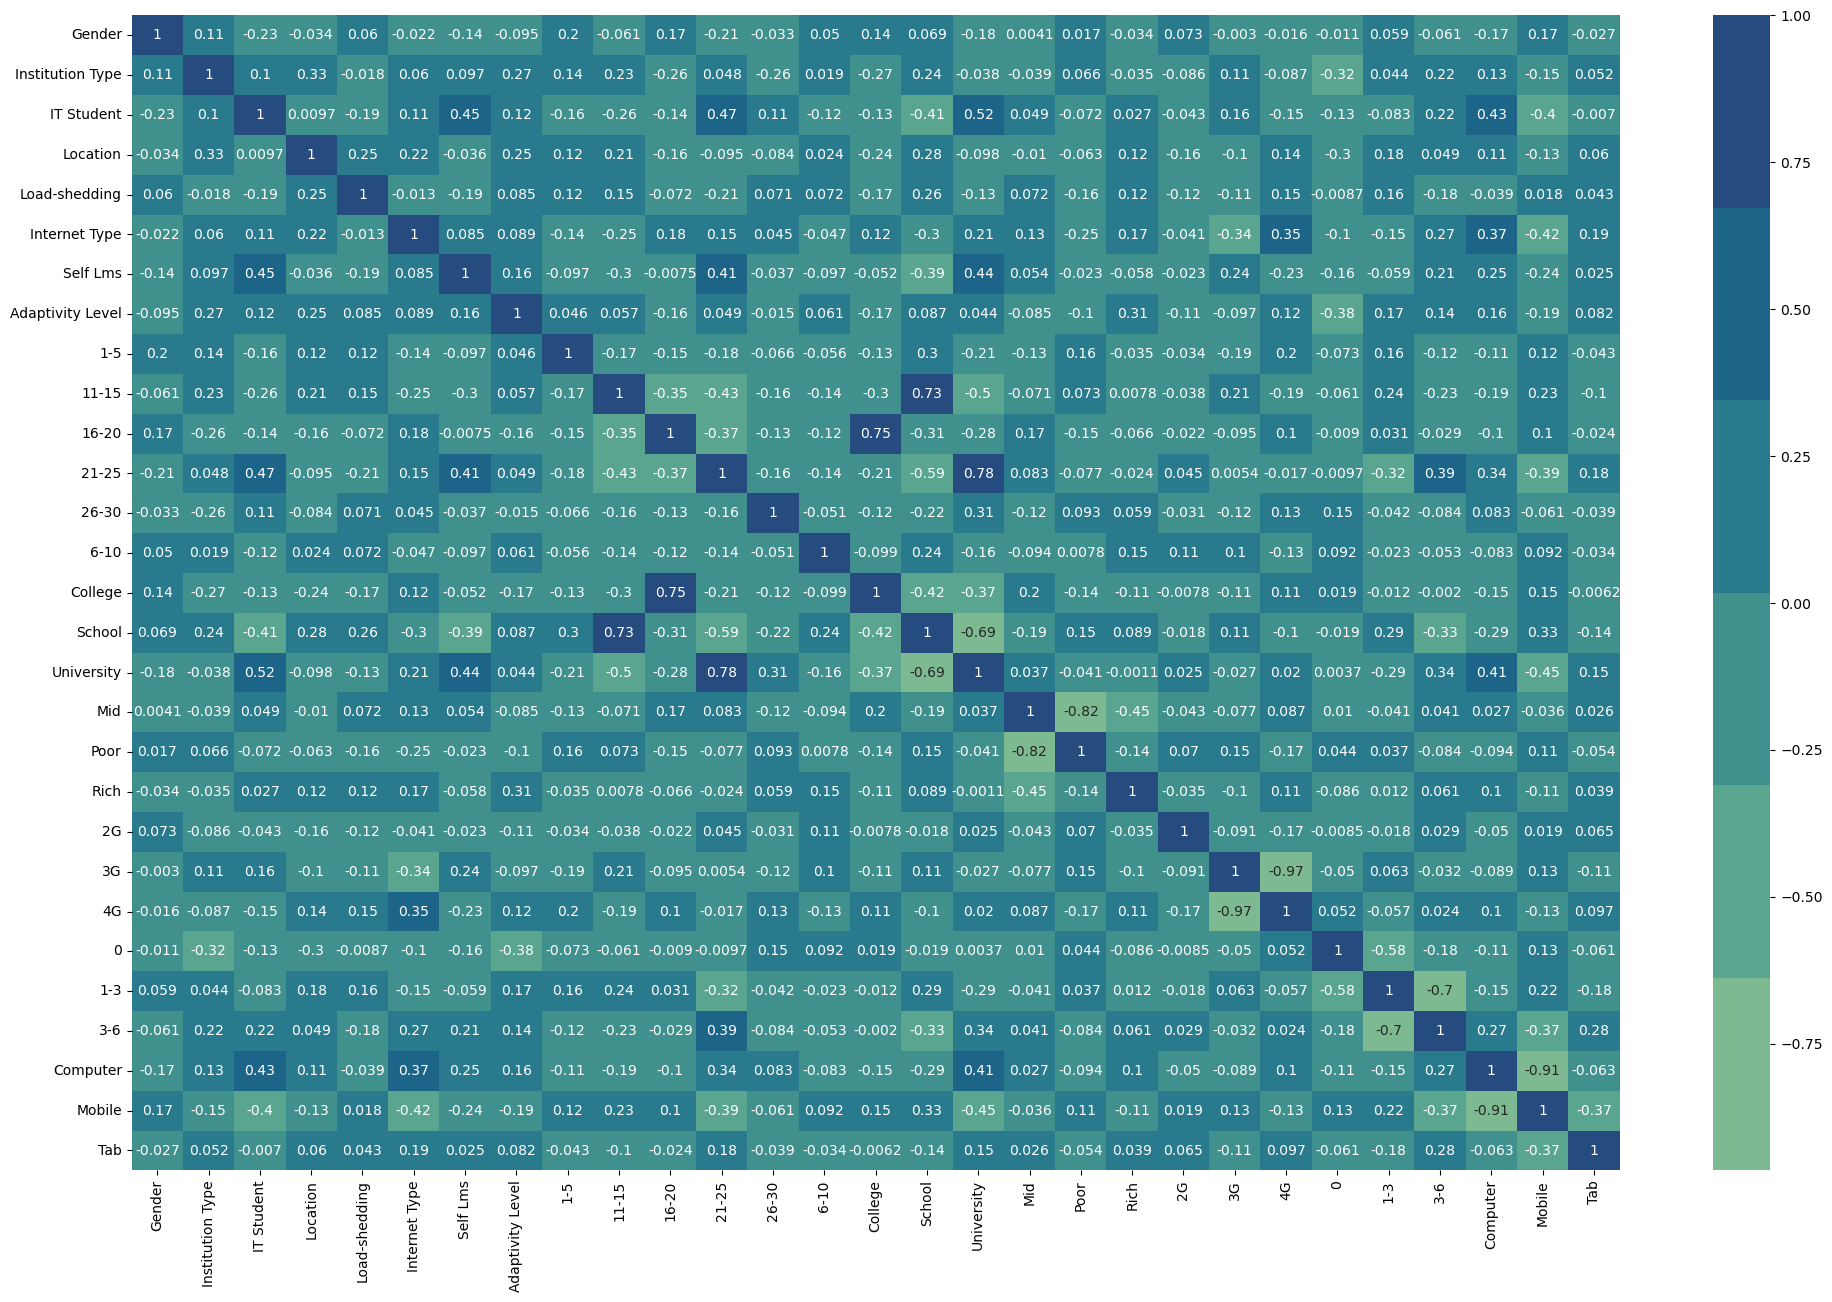

In [33]:
# Early correlation matrix to understand relationships within the features that are being analyzed

plt.figure(figsize= (24,15))
corrM = data.corr()

sns.heatmap(corrM, annot = True, cmap=pal)
plt.show()

The correlation matrix seems to indicate that no one variable highly correlates with adaptivity level, either positvely or negatively. This may indicate that no one feature has an outsized impact on the dependent variable. There is also high correlation between categorical features that have been processed into seperate columns which would be expected. 

In [34]:
#split dataset into dependent variables and indepedent variables

aspects = data.drop(columns=['Adaptivity Level'], axis=1)
target = data['Adaptivity Level']

In [35]:
#initial inspection of the distribution of values
aspects.describe()

Gender  Institution Type   IT Student     Location  Load-shedding  \
count  1205.000000       1205.000000  1205.000000  1205.000000    1205.000000   
mean      0.449793          0.682988     0.252282     0.775934       0.833195   
std       0.497679          0.465506     0.434503     0.417139       0.372956   
min       0.000000          0.000000     0.000000     0.000000       0.000000   
25%       0.000000          0.000000     0.000000     1.000000       1.000000   
50%       0.000000          1.000000     0.000000     1.000000       1.000000   
75%       1.000000          1.000000     1.000000     1.000000       1.000000   
max       1.000000          1.000000     1.000000     1.000000       1.000000   

       Internet Type     Self Lms          1-5        11-15        16-20  ...  \
count    1205.000000  1205.000000  1205.000000  1205.000000  1205.000000  ...   
mean        0.423237     0.174274     0.067220     0.292946     0.230705  ...   
std         0.494277     0.379502     0.250506     0.455303     0.421459  ...   
min         0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%         0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%         0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%         1.000000     0.000000     0.000000     1.000000     0.000000  ...   
max         1.000000     1.000000     1.000000     1.000000     1.000000  ...   

              Rich           2G           3G           4G            0  \
count  1205.000000  1205.000000  1205.000000  1205.000000  1205.000000   
mean      0.070539     0.015768     0.341079     0.643154     0.127801   
std       0.256160     0.124627     0.474269     0.479268     0.334007   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     1.000000     0.000000   
75%       0.000000     0.000000     1.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               1-3          3-6     Computer       Mobile          Tab  
count  1205.000000  1205.000000  1205.000000  1205.000000  1205.000000  
mean      0.697095     0.175104     0.134440     0.840664     0.024896  
std       0.459705     0.380214     0.341266     0.366141     0.155874  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     1.000000     0.000000  
50%       1.000000     0.000000     0.000000     1.000000     0.000000  
75%       1.000000     0.000000     0.000000     1.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 28 columns]

Looking at the distribution of values within the features, scaling should not be an issue since all of the values in the dataset are categorical their numercal values are on the same scale AKA 0 or 1. It is interesting to get an idea of the distribution of the different features. For example for Gender there seems to be a roughly equal distribtuion of men and women, but for Device the majority of entries used mobile devices.

In [36]:
#inspection of dependent variable distribution
target.value_counts()

1    625
0    480
2    100
Name: Adaptivity Level, dtype: int64

The distribution of the dependent variable values in this dataset are not equally distributed. There are many more moderate or low adaptibility entries then there are high adaptiblity. This unequal distribution may need to be something that is taken into account when assessing the accuracy of the model. 

# Building Baseline Models

In order to determine which baseline model is appropriate for the dataset, three initial models will be built using the dataset. Once built, the most accurate baseline model will be selected to fine tune and build upon. The F1 score will be used as a determinate of which model is the most accurate. The reason the F1 score will be used is that, as an expression of the precision and recall of the model, the higest F1 score limits the amount of false positives and negatives. This is important since the project wants a model to correctly assess the adaptibility level of students at all three levels (low, moderate & high). 

## Baseline Logistic Regression Model

In [37]:
#instatiate a test train split

X = aspects
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, \
                                                    random_state = 42)

In [38]:
#instantiate logistic regression model
logreg = LogisticRegression(random_state=123)

#fit the model onto the train sets
logreg.fit(X_train,y_train)
logreg

#predict values of the model
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

#evaluate model 
names = ['Low Adaptibility','Moderate Adaptibility','High Adaptibility']
f1_logreg = round(f1_score(y_test,y_hat_test,average='macro'),3)
print(classification_report(y_test,y_hat_test,target_names=names))

                       precision    recall  f1-score   support

     Low Adaptibility       0.75      0.63      0.69       127
Moderate Adaptibility       0.68      0.83      0.75       144
    High Adaptibility       0.75      0.48      0.59        31

             accuracy                           0.71       302
            macro avg       0.73      0.65      0.67       302
         weighted avg       0.72      0.71      0.71       302



## Baseline KNN Model

In [39]:
#instantiate 
knn_baseline_model = KNeighborsClassifier()

#fit onto the data
knn_baseline_model.fit(X_train,y_train)

#predict
y_hat_train = knn_baseline_model.predict(X_train)
y_hat_test = knn_baseline_model.predict(X_test)

#evaluate model 
f1_knn = round(f1_score(y_test,y_hat_test,average='macro'),3)
print(classification_report(y_test,y_hat_test,target_names=names))

                       precision    recall  f1-score   support

     Low Adaptibility       0.84      0.72      0.77       127
Moderate Adaptibility       0.73      0.90      0.80       144
    High Adaptibility       0.76      0.42      0.54        31

             accuracy                           0.77       302
            macro avg       0.78      0.68      0.71       302
         weighted avg       0.78      0.77      0.76       302



## Baseline Decision Tree Model

In [40]:
#instantiate 
clf = DecisionTreeClassifier(criterion='entropy',random_state=123)

#fit the model onto the train sets
clf.fit(X_train,y_train)

#predict 
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

#evaluate model
f1_tree = round(f1_score(y_test,y_hat_test,average='macro'),3)
print(classification_report(y_test,y_hat_test,target_names=names))

                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.89      0.91       127
Moderate Adaptibility       0.87      0.94      0.91       144
    High Adaptibility       0.85      0.71      0.77        31

             accuracy                           0.90       302
            macro avg       0.89      0.85      0.86       302
         weighted avg       0.90      0.90      0.90       302



# Selecting A Baseline Model

In [41]:
#import the metrics library
print(f'f1-score of baseline logistic regression is {f1_logreg}')
print(f'f1-score of knn model is {f1_knn}')
print(f'f1-score of baseline decision tree is {f1_tree}')

f1-score of baseline logistic regression is 0.675
f1-score of knn model is 0.707
f1-score of baseline decision tree is 0.865


Comparing all three baseline models F1 scores, it appears that the baseline decision tree model is significantly higher then the KNN baseline model and the logistic regression model. Knowing this, further exploration and modifications will be implemented to the decision tree model.

# Decision Tree Model

In [42]:
#re-run the basline model so all variables are updated correctly
#for the train and test sets

#instantiate 
clf = DecisionTreeClassifier(criterion='entropy',random_state=123)

#fit the model onto the train sets
clf.fit(X_train,y_train)
clf

#predict 
y_tree_train = clf.predict(X_train)
y_tree_test = clf.predict(X_test)

print('TRAIN SCORES')
print(classification_report(y_train,y_tree_train,target_names=names))
print('--------------------------------------------------------------')
print('TEST SCORES')
print(classification_report(y_test,y_tree_test,target_names=names))

accuracy_tree_train = accuracy_score(y_train,y_tree_train)
accuracy_tree_test = accuracy_score(y_test,y_tree_test)

f1_score_tree_train = f1_score(y_train,y_hat_train,average='macro')
f1_score_tree_test = f1_score(y_test,y_hat_test,average='macro')

TRAIN SCORES
                       precision    recall  f1-score   support

     Low Adaptibility       0.93      0.95      0.94       353
Moderate Adaptibility       0.94      0.94      0.94       481
    High Adaptibility       0.92      0.80      0.85        69

             accuracy                           0.93       903
            macro avg       0.93      0.90      0.91       903
         weighted avg       0.93      0.93      0.93       903

--------------------------------------------------------------
TEST SCORES
                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.89      0.91       127
Moderate Adaptibility       0.87      0.94      0.91       144
    High Adaptibility       0.85      0.71      0.77        31

             accuracy                           0.90       302
            macro avg       0.89      0.85      0.86       302
         weighted avg       0.90      0.90      0.90       302



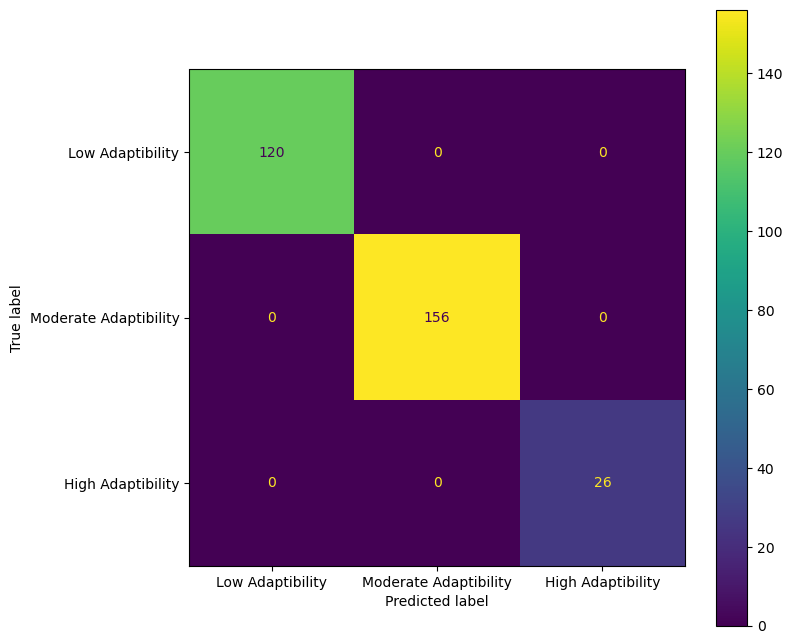

In [43]:
#Plot the confusion matrix of the Decision Tree Model
fig,ax=plt.subplots(figsize=(8,8))
plot_confusion_matrix(clf,X_test,y_tree_test,ax=ax,display_labels=names);

Looking at the performance of the train dataset versus the test dataset in the Decision Tree Model, it appears the model is over fitting to the training data. In particular, the value of high adaptibility appears to show the greatest variation between the train data and the test data. This could be because high adaptibility students are the smallest group in the dataset compared to Low and Moderate adaptibility groups. In order to try and improve the f1 score, hyperparameter tuning might lead to an increase without modifying the actual dataset itself. 

According to the Confusion Matrix, the model is working perfectly to elminate false negatives and false positives. However, this may be due to having a dataset with a smaller amount of entries. As a result, for a confusion matrix to be an accuarate assessment of how well the model is performing, more data would need to be added to the dataset. 

# Hyperparameter Tuning

Since the Decision Tree Model is overfitting to the training data, Tree Pruning is necessary to reduce over fitting and hopefully increase the f1 score of the model. In order to prune effectively, optimal Max_Depth, Min_Samples_Split, & Min_Samples_Leaf must be determined. In order to make sure that effective parameter ranges are being picked, the current parameters that were automatically set need to be found. 

In [44]:
#determine default parameters
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

According to the presets, there was no value assigned for max_depth. As a result a range to explore the optimal values will be assigned to explore the affect of this parameter.

## Determining Optimal Max_Depth

Text(0.5, 1.0, 'max_depth')

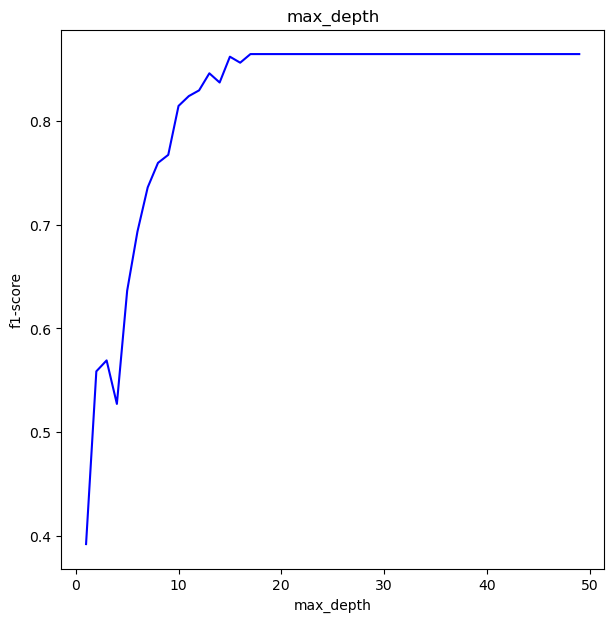

In [45]:
#creating a list of depth values
max_depth = np.arange(1,50)

#creating an empty list to store scores for each depth
f1_test_scores = []


# create a loop for the classifier to run with the different depth values
for depth in max_depth:
    
    #instantiate
    classifier = DecisionTreeClassifier(criterion='entropy',max_depth=depth,random_state=123)
    
    #fit the model
    classifier.fit(X_train,y_train)
    
    #predict values
    y_hat_test = classifier.predict(X_test)
    
    #calculate
    f1 = f1_score(y_test,y_hat_test,average='macro')    

    
    #add the scores to the list
    f1_test_scores.append(f1)

    
#visualize the data
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(max_depth,f1_test_scores,c='b')
ax.set_xlabel('max_depth')
ax.set_ylabel('f1-score')
ax.set_title('max_depth')

The accuracy of the model peaks at max_depth 20 and levels off. This will be the optimal value for our adjusted Decision Tree Model. 

## Determining Optimal Min_Samples_Split

In the original min_samples_split default settings, the value was set to 2. Therefore the range will be set to include the default and higher values to see if a more optimal value for the parameter can be determined. 

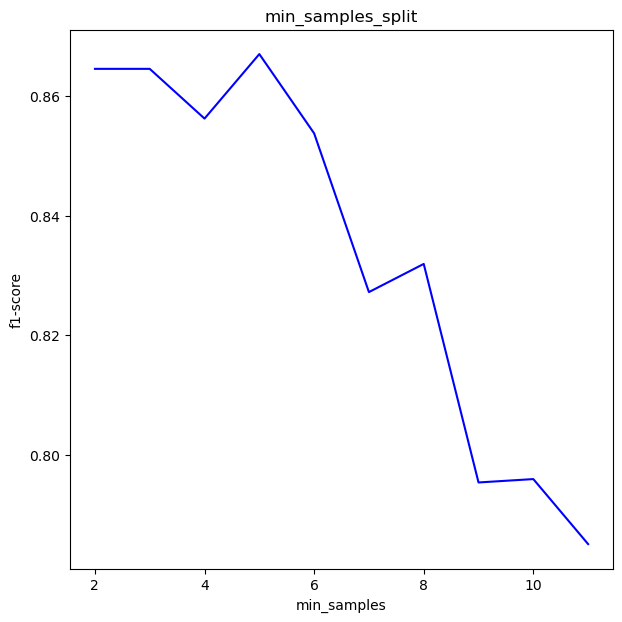

In [46]:
#use the optimum value of depth
depth = 20

#define a range of min_samples_for each split
min_samples_range = np.arange(2,12)

#create a loop with the optimum depth and different min_samples
#creating an empty list to store scores for each depth
f1_test_scores = []

# create a loop for the classifier to run with the different depth values
for sample in min_samples_range:
    
    #instantiate
    classifier = DecisionTreeClassifier(criterion='entropy',max_depth=depth,min_samples_split=sample,random_state=123)
    
    #fit the model
    classifier.fit(X_train,y_train)
    
    #predict values
    y_hat_test = classifier.predict(X_test)
    
    #calculate
    f1 = f1_score(y_test,y_hat_test,average='macro')    
    
    #add the scores to the list
    f1_test_scores.append(f1)


#visualize
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(min_samples_range,f1_test_scores,c='b')

ax.set_xlabel('min_samples')
ax.set_ylabel('f1-score')
ax.set_title('min_samples_split')
plt.show();

The accuracy of the model peaks at min_samples 5 and then sharply decreases. This will be the optimal value for our adjusted Decision Tree Model.

## Determining Optimal Min_Samples_Leaf

In the default setting for the Baseline Decision Tree Model, the Min_Samples_Leaf was set to 2. In order to try and optimize the parameter setting, a range will be set that includes 2 but explores values higher. 

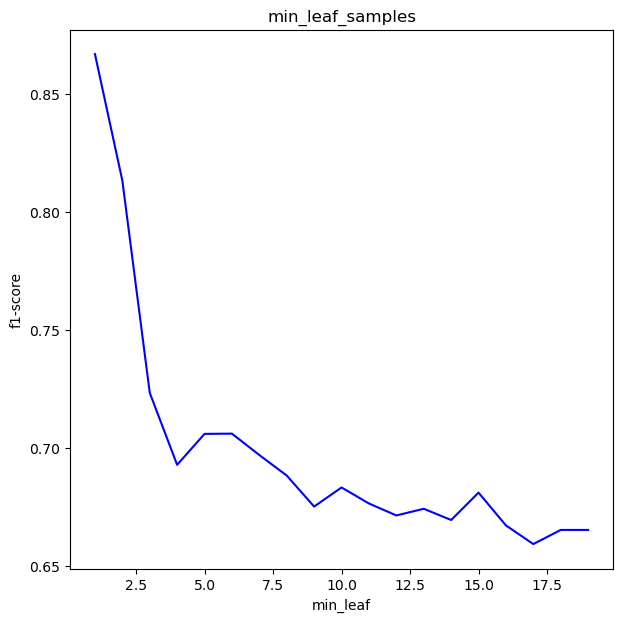

In [47]:
#use the optimum value of depth,min_samples_split
depth = 20
min_samples = 5

#define a range of min_samples_for each split
min_leaf_range = np.arange(1,20)

#create a loop with the optimum depth and different min_samples
#creating an empty list to store scores for each depth
f1_test_scores = []

# create a loop for the classifier to run with the different depth values
for sample in min_leaf_range:
    
    #instantiate
    classifier = DecisionTreeClassifier(criterion='entropy',max_depth=depth,min_samples_split=min_samples,
                                       min_samples_leaf=sample, random_state=123)
    
    #fit the model
    classifier.fit(X_train,y_train)
    
    #predict values
    y_hat_test = classifier.predict(X_test)
    
    #calculate
    f1 = f1_score(y_test,y_hat_test,average='macro')    
    
    #add the scores to the list
    f1_test_scores.append(f1)


#visual
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(min_leaf_range,f1_test_scores,c='b')

ax.set_xlabel('min_leaf')
ax.set_ylabel('f1-score')
ax.set_title('min_leaf_samples')

plt.show();

The accuracy of the model peaks at the min_leaf value of 2 and sharply decreases. This will be the optimal value for our adjusted Decision Tree Model. 

# Decision Tree Model with Optimized Parameters

In [48]:
#run the model with the optimized parameters
depth=20
min_samples=5
leaf=2

#instantiate
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=depth,min_samples_split=min_samples,
                                    min_samples_leaf=leaf,random_state=123)

#fit the model
classifier.fit(X_train,y_train)

#predict values
y_hat_train = classifier.predict(X_train)
y_hat_test = classifier.predict(X_test)

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,y_hat_train,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,y_hat_test,target_names=names))

accuracy_optimized_train = accuracy_score(y_train,y_hat_train)
accuracy_optimized_test = accuracy_score(y_test,y_hat_test)

f1_score_optimized_train = f1_score(y_train,y_hat_train,average='macro')
f1_score_optimized_test = f1_score(y_test,y_hat_test,average='macro')

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.92      0.93      0.93       353
Moderate Adaptibility       0.93      0.93      0.93       481
    High Adaptibility       0.89      0.78      0.83        69

             accuracy                           0.92       903
            macro avg       0.91      0.88      0.89       903
         weighted avg       0.92      0.92      0.92       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.91      0.84      0.88       127
Moderate Adaptibility       0.83      0.92      0.87       144
    High Adaptibility       0.79      0.61      0.69        31

             accuracy                           0.86       302
            macro avg       0.84      0.79      0.81       302
         weighted avg       0.86  

The AUC and f1 score of the Decision Tree Model actually went down after this hyperparamter tuning. This is most likely because tuning each individual hyperparameter was not as effective at finding the optimal parameters with this smaller less complicated dataset. A more sophisticated parameter tuning tool like grid search may be more effective. 

## Tuning the Decision Tree with GridSearchCV

Since additional tuning can be done more effectively with the GridSearch tool, the ranges were expanded from the original parameter tuning in order to explore more possible values to find the optimal parameters. As a result the criterion options will be explored in this tuning, more values will be explored in max_depth, min_samples_split, and min_samples_leaf.

In [49]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_split': [1, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

gs_tree = GridSearchCV(clf, param_grid, cv = 5, scoring='accuracy')
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [50]:
#get predictions from the gridsearch

#predict values
y_gst_train = gs_tree.predict(X_train)
y_gst_test = gs_tree.predict(X_test)

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,y_gst_train,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,y_gst_test,target_names=names))

accuracy_gst_train = accuracy_score(y_train,y_gst_train)
accuracy_gst_test = accuracy_score(y_test,y_gst_test)

f1_score_gst_train = f1_score(y_train,y_gst_train,average='macro')
f1_score_gst_test = f1_score(y_test,y_gst_test,average='macro')

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.92      0.94      0.93       353
Moderate Adaptibility       0.93      0.94      0.93       481
    High Adaptibility       0.92      0.80      0.85        69

             accuracy                           0.93       903
            macro avg       0.92      0.89      0.91       903
         weighted avg       0.93      0.93      0.93       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.88      0.91       127
Moderate Adaptibility       0.86      0.94      0.90       144
    High Adaptibility       0.84      0.68      0.75        31

             accuracy                           0.89       302
            macro avg       0.88      0.83      0.85       302
         weighted avg       0.89  

Using GridSearch, the accuracy of the model saw a slight increase. Though the accuracy of the train remained the same, there was a slight increase from an accuracy value of .86 on the baseline model to .89 for the test data. Fine tuning the parameters helped minimize the overfitting of the model to the train data without sacrificing the accuracy of the train data, not an easy feat to acheive. So far this optimized Decision Tree is the most accurate model, but in order to confirm this as the best model to acheive the goals of this project ensemble models will be explored to see if a more accurate model for the dataset can be found. 

## Random Forest Classifier Model

A Random Forest Classifier model utilizes multiple Decision Tree Models in order to increase the accuracy of the model overall. Since the Decision Tree Model was so successful with this dataset, it's worth exploring this ensemble method model to see if there are any gains in accuracy.  

In [51]:
#build a baseline Random Forest Classifier

rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [52]:
#predict values
y_rfc_train = rfc.predict(X_train)
y_rfc_test = rfc.predict(X_test)

In [53]:
#fit the model
rfc.fit(X_train,y_train)

#predict values
y_rfc_train = rfc.predict(X_train)
y_rfc_test = rfc.predict(X_test)

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,y_rfc_train,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,y_rfc_test,target_names=names))

accuracy_rfc_train = accuracy_score(y_train,y_rfc_train)
accuracy_rfc_test = accuracy_score(y_test,y_rfc_test)

f1_score_rfc_train = f1_score(y_train,y_rfc_train,average='macro')
f1_score_rfc_test = f1_score(y_test,y_rfc_test,average='macro')

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.91      0.97      0.94       353
Moderate Adaptibility       0.98      0.85      0.91       481
    High Adaptibility       0.59      1.00      0.75        69

             accuracy                           0.90       903
            macro avg       0.83      0.94      0.86       903
         weighted avg       0.93      0.90      0.91       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.93      0.92      0.92       127
Moderate Adaptibility       0.93      0.86      0.89       144
    High Adaptibility       0.67      0.90      0.77        31

             accuracy                           0.89       302
            macro avg       0.84      0.90      0.86       302
         weighted avg       0.90  

The AUC of the Random Forest Model is similar but less then the AUC value of the opimtized Decision Tree. The model also seems to be performing less consistently across all three adaptiblity levels which is not ideal. Using GridSearch, it will be determined if tuning the model can lead to a more consistent and higher AUC value for the test and train datasests. 

## Tuning the Random Forest Classifier with GridSearchCV

In [54]:
#determine default parameters
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [55]:
#define a param grid based on defaults

param_grid = {'criterion':['gini','entropy'],
              'max_depth':[3,6,9,12,15,20],
              'min_samples_leaf': [1,5,10],
              'min_samples_split': [2,4,6,8]
             }

In [56]:
#fit the gridsearch

rf = RandomForestClassifier(class_weight= 'balanced')
grid_rfc = GridSearchCV(rf, param_grid, cv = 5, scoring='accuracy')
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 12, 15, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [57]:
#print the best parameters

grid_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [58]:
#get predictions from the gridsearch

#predict values
y_grf_train = grid_rfc.predict(X_train)
y_grf_test = grid_rfc.predict(X_test)

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,y_grf_train,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,y_grf_test,target_names=names))

accuracy_grf_train = accuracy_score(y_train,y_grf_train)
accuracy_grf_test = accuracy_score(y_test,y_grf_test)

f1_score_grf_train = f1_score(y_train,y_grf_train,average='macro')
f1_score_grf_test = f1_score(y_test,y_grf_test,average='macro')

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.93      0.95      0.94       353
Moderate Adaptibility       0.97      0.86      0.91       481
    High Adaptibility       0.59      1.00      0.75        69

             accuracy                           0.91       903
            macro avg       0.83      0.94      0.87       903
         weighted avg       0.93      0.91      0.91       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.92      0.93       127
Moderate Adaptibility       0.93      0.87      0.90       144
    High Adaptibility       0.67      0.90      0.77        31

             accuracy                           0.89       302
            macro avg       0.84      0.90      0.86       302
         weighted avg       0.90  

Using GridSearch the AUC score of the Random Forest Classifier model for the test data was able to increase to .89 which is comparable to the optimized Decision Tree Model. One more model, XGBoost, will be explored before settling on a final model.  

## XGBoost Model

The XGBoost Model also utilizes Decision Trees but also incorporates gradient boosting and scaling. This makes the XGBoost model adept at avoiding over fitting. Using this model will hopefully allow for more consistent AUC scores across the Test and Train data. 

In [59]:
y_train.value_counts().sort_index()

0    353
1    481
2     69
Name: Adaptivity Level, dtype: int64

In [60]:
# Instantiate XGBClassifier
xgb = XGBClassifier(eval_metric='mlogloss')

# Fit XGBClassifier
xgb.fit(X_train, y_train)

# Predict on training and test sets
y_xgb_train = xgb.predict(X_train)
y_xgb_test = xgb.predict(X_test)

accuracy_xgb_train = accuracy_score(y_train,y_xgb_train)
accuracy_xgb_test = accuracy_score(y_test,y_xgb_test)

f1_score_xgb_train = f1_score(y_train,y_xgb_train,average='macro')
f1_score_xgb_test = f1_score(y_test,y_xgb_test,average='macro')

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,y_xgb_train,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,y_xgb_test,target_names=names))

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.93      0.95      0.94       353
Moderate Adaptibility       0.94      0.94      0.94       481
    High Adaptibility       0.92      0.80      0.85        69

             accuracy                           0.93       903
            macro avg       0.93      0.90      0.91       903
         weighted avg       0.93      0.93      0.93       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.91      0.92       127
Moderate Adaptibility       0.88      0.95      0.92       144
    High Adaptibility       0.88      0.71      0.79        31

             accuracy                           0.91       302
            macro avg       0.90      0.86      0.88       302
         weighted avg       0.91  

The XGBoost Model is the only model that has as high AUC levels for the training data as the Decision Tree Model, however where it out performs is in the testing data. The F1 score for all adaptivity levels is higher in the testing data in any of the other models that have been explored. As promised, the XGBoost has done a much better job minimzing overfitting compared to the other models trained on the dataset. Before deciding on which model to utilize, GridSearch will be implemented on the XGBoost Model to find the optimal parameters. 

## Tuning the XGBoost Model with GridSearchCV

In [61]:
#determine default parameters
xgb.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'mlogloss'}

Since there are many more possible parameters to tune for an XGBoost model, research was done to determine a possibly sucessful parameter grid to explore optimizing the XGBoost model. These parameters were found in an article [HERE](https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost) on the website Kaggle. 

In [62]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }

In [63]:
xgb = XGBClassifier(eval_metric='mlogloss')
grid_xgb = GridSearchCV(xgb, params, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train, y_train)

best_xgb_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_xgb_parameters.keys()):
    print('%s: %r' % (param_name, best_xgb_parameters[param_name]))

Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 0
max_depth: 6
min_child_weight: 1
subsample: 0.8


In [64]:
grid_xgb_training_preds = grid_xgb.predict(X_train)
grid_xgb_test_preds = grid_xgb.predict(X_test)

accuracy_grid_xgb_train = accuracy_score(y_train,grid_xgb_training_preds)
accuracy_grid_xgb_test = accuracy_score(y_test,grid_xgb_test_preds)

f1_score_grid_xgb_train = f1_score(y_train,grid_xgb_training_preds,average='macro')
f1_score_grid_xgb_test = f1_score(y_test,grid_xgb_test_preds,average='macro')

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,grid_xgb_training_preds,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,grid_xgb_test_preds,target_names=names))

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.93      0.95      0.94       353
Moderate Adaptibility       0.94      0.94      0.94       481
    High Adaptibility       0.92      0.80      0.85        69

             accuracy                           0.93       903
            macro avg       0.93      0.90      0.91       903
         weighted avg       0.93      0.93      0.93       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.94      0.94       127
Moderate Adaptibility       0.91      0.95      0.93       144
    High Adaptibility       0.88      0.71      0.79        31

             accuracy                           0.92       302
            macro avg       0.91      0.87      0.89       302
         weighted avg       0.92  

The new optimized parameters made a slight improvement in the AUC value for the test data, in particular by increasing the F1 score of the Low and Moderate Adaptiblity. The high Adaptability F1 score is at a similar value as before the optimization. However, this overall increase for the test data will be extremely helpful in determing the importance of individual features according to the model. 

## Visualize Scores Between Models

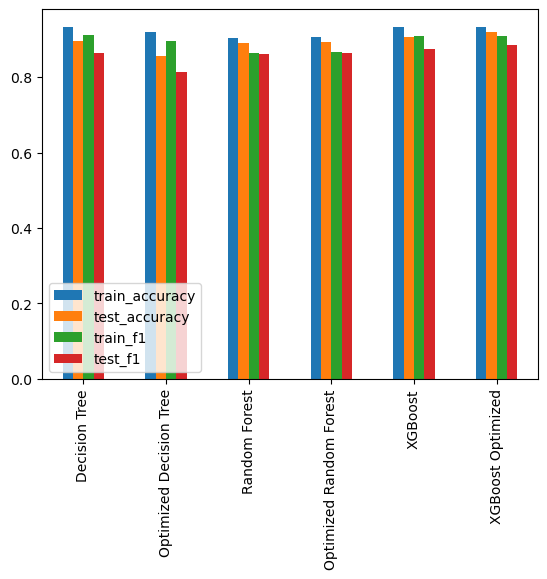

In [65]:
# create a dataframe of the scores for the different models
score_df = pd.DataFrame({'train_accuracy': [accuracy_tree_train, accuracy_optimized_train, accuracy_rfc_train,
                                           accuracy_grf_train, accuracy_xgb_train, accuracy_grid_xgb_train],
                        'test_accuracy': [accuracy_tree_test, accuracy_optimized_test, accuracy_rfc_test,
                                           accuracy_grf_test, accuracy_xgb_test, accuracy_grid_xgb_test],
                        'train_f1': [f1_score_tree_train, f1_score_optimized_train, f1_score_rfc_train,
                                           f1_score_grf_train, f1_score_xgb_train, f1_score_grid_xgb_train],
                         'test_f1': [f1_score_tree_test, f1_score_optimized_test, f1_score_rfc_test,
                                           f1_score_grf_test, f1_score_xgb_test, f1_score_grid_xgb_test]
                        }, index=['Decision Tree', 'Optimized Decision Tree','Random Forest', 
                                  'Optimized Random Forest', 'XGBoost', 'XGBoost Optimized'])


#plot the data
score_df.plot.bar()
plt.legend(loc='lower left');

Using the visualization, the XGBoost Optimized has one of the highest AUC values and F1 scores. Most importantly though, the AUC values and F1 scores are the closest between the test and train data. This shows that the optimized XGBoost is the best model to use for accuracy but also because it avoided overfitting to the train dataset. This will be the model that will be utilized for prediction and determing feature importance. 

## Confusion Matrix

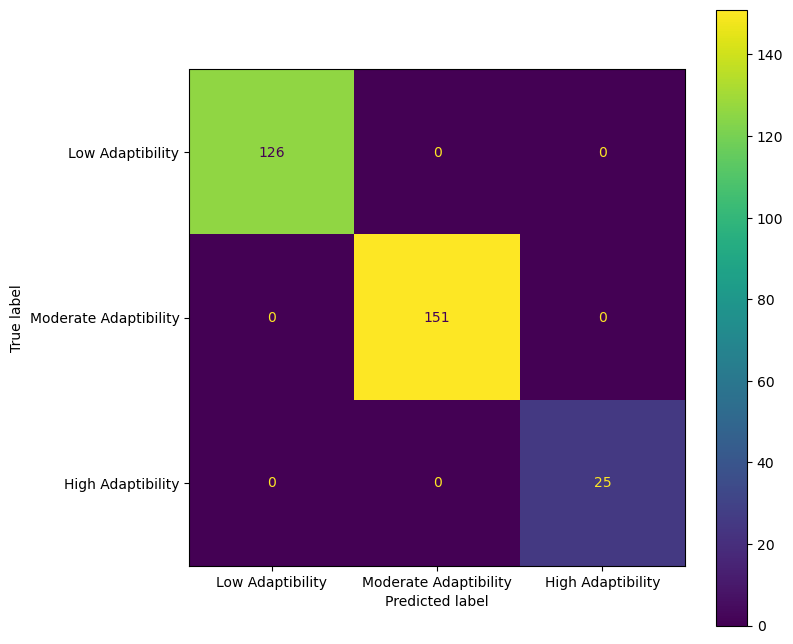

In [66]:
#Plot the confusion matrix of the XGBoost Model
fig,ax=plt.subplots(figsize=(8,8))
plot_confusion_matrix(grid_xgb,X_test,grid_xgb_test_preds,ax=ax,display_labels=names);

According to the confusion matrix above, the XGBoost model is predicting true positives for every category of adaptiblity level. This supports that the AUC level is the highest in the XGBoost model. It also is important to note that the Baseline Decision Tree Model for the test data also performed perfectly according to the Classification Matrix. However, the realtively smaller size of the dataset is possibly affecting the usefulness of this tool as an assessment of the success of the models for this project. 

## XGBoost Feature Importance

Now that the most successful model has been selected, this model will be used to determine the impact of individual features on the models predictions. By determining these impacts, recommendations can be made proactively or as solutions for students who are in the low or moderate adaptibility level for online education. In order to determine the feature importance according to the XGBoost optimized model, an article found [HERE] (https://mljar.com/blog/feature-importance-xgboost/) laid out three ways to code and explore feature importance. These three methods are the Built In Feature Importance function, permutation importance, and SHAP. All three methods will be explored to determine which will give the most valuable information for the business problem.

## XGBoost Final Model

In [67]:
#assigning optimized XGBoost as Final Model
final_model = XGBClassifier(eval_metric='mlogloss', colsample_bytree=.8, gamma= 0, max_depth=6, min_child_weight=1, 
                    subsample=0.8)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
#Checking Final Models AUC and F1 Score Values
final_model_training_preds = final_model.predict(X_train)
final_model_test_preds = final_model.predict(X_test)

accuracy_final_model_train = accuracy_score(y_train,final_model_training_preds)
accuracy_final_model_test = accuracy_score(y_test,final_model_test_preds)

f1_score_final_model_train = f1_score(y_train,final_model_training_preds,average='macro')
f1_score_final_model_test = f1_score(y_test,final_model_test_preds,average='macro')

#scores
print('TRAIN SCORES')
print('---------------------------------------------------------')
print(classification_report(y_train,final_model_training_preds,target_names=names))
print('TEST SCORES')
print('----------------------------------------------------------')
print(classification_report(y_test,final_model_test_preds,target_names=names))

TRAIN SCORES
---------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.93      0.95      0.94       353
Moderate Adaptibility       0.94      0.94      0.94       481
    High Adaptibility       0.92      0.80      0.85        69

             accuracy                           0.93       903
            macro avg       0.93      0.90      0.91       903
         weighted avg       0.93      0.93      0.93       903

TEST SCORES
----------------------------------------------------------
                       precision    recall  f1-score   support

     Low Adaptibility       0.94      0.94      0.94       127
Moderate Adaptibility       0.91      0.95      0.93       144
    High Adaptibility       0.88      0.71      0.79        31

             accuracy                           0.92       302
            macro avg       0.91      0.87      0.89       302
         weighted avg       0.92  

## Xgboost Built-in Feature Importance

Text(0.5, 0, 'Xgboost Feature Importance')

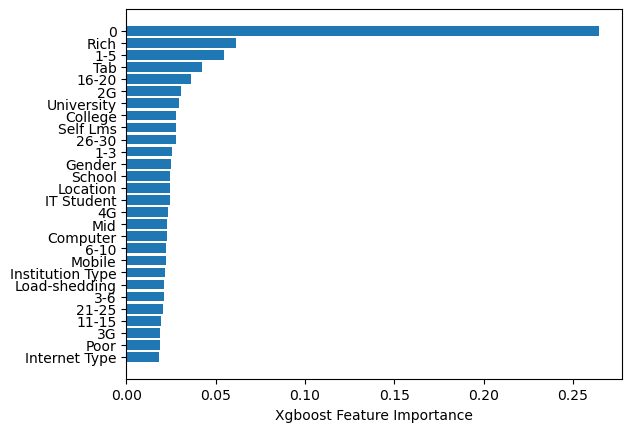

In [69]:
# plot feature importance
sorted_idx = final_model.feature_importances_.argsort()
plt.barh(aspects.columns[sorted_idx], final_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

## Permutation Based Feature Importance

In [70]:
perm_importance = permutation_importance(final_model, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

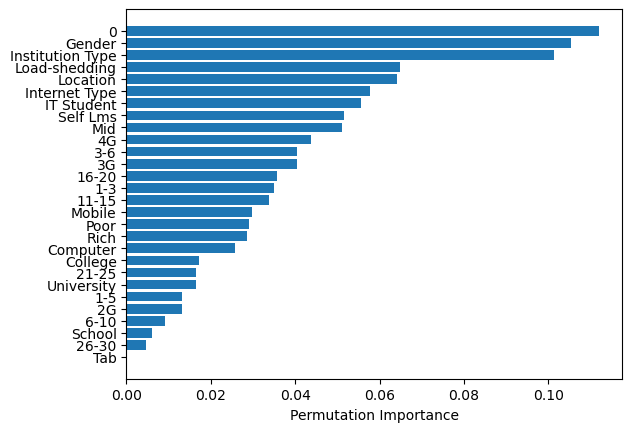

In [71]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(aspects.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

## Feature Importance Computed with SHAP Values

In [72]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

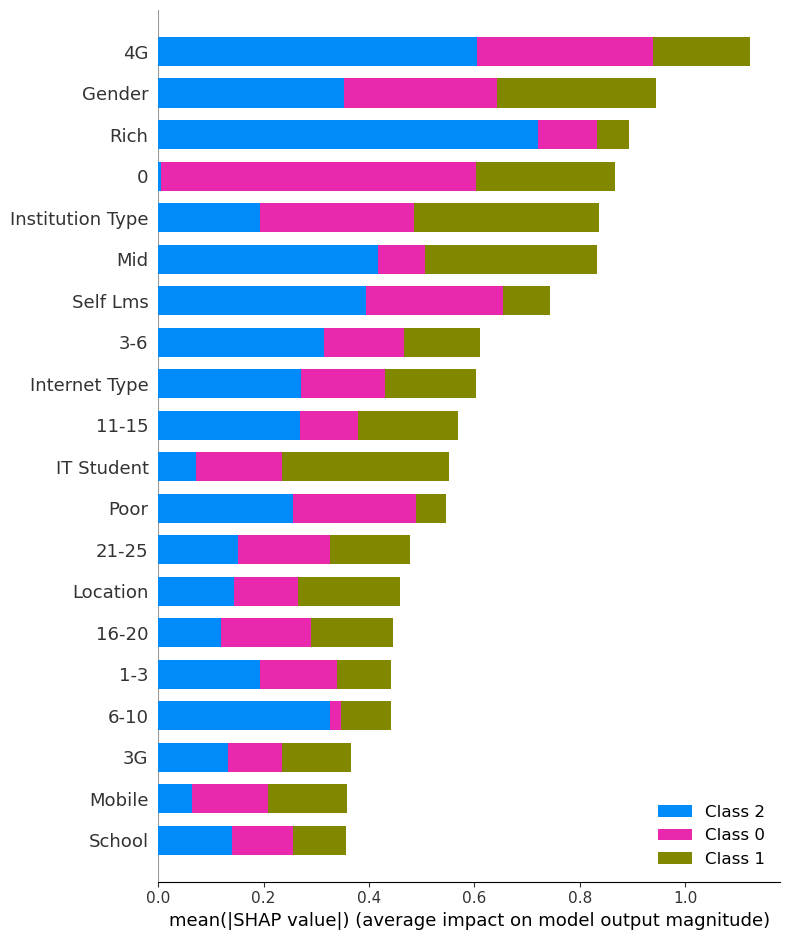

In [73]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

A lot of really interesting trends are emerging from these three different feature importance computations. However, a drawback of the binary coding technique utilized in pre-processing is that we don't see how those binary categories are important. For example, knowing gender as a feature is important is interesting but doesn't 